# Python Tutorial Program: Organizing Regression Results into a DataFrame, then Plotting the Regression Coefficients as a Grouped Bar Chart

By Kenneth Burchfiel

Released under the MIT license

**For more background on this program, please see my correspodning blog post here: https://kburchfiel3.wordpress.com/2021/07/24/python-tutorial-program-organizing-regression-results-into-a-dataframe-then-plotting-the-regression-coefficients-as-a-grouped-bar-chart/ **

This program demonstrates how Python can be used to determine the statistical significance of an intervention via a Difference-in Differences analysis, then display the effects of that intervention through a series of graphs. 

It performs the following tasks:

1. Import a table containing **fictional** beginning-of-year and end-of-year test score data for students in multiple high schools and grades

1. Create individual Pandas DataFrames for each school

2. Perform a regression for each school-grade pair that incorporates 3 variable: (1) time (beginning of year vs. end of year); (2) intervention group; and (3) time-intervention group interaction

3. Append these results to a table for easier comparison/analysis

4. Use this regression data to create and save charts that compare test score improvements for two groups of students

5. Create additional charts that visualize certain regression coefficients and indicate statistical significance

6. Output the table of regression results to an .xlsx worksheet

## Scenario:
(Note: both the scenario and the data presented in this program are fictional.)

Orange Valley School District (OVSD) is piloting an after-school math program called Code the Concepts in each of its 8 high schools. This program aims to teach students relevant math skills through programming and computer science applications, and is available in grades 9-12.

Although the district believes that the programming knowledge taught in this course is highly valuable in itself, it also wants to evaluate the impact, if any, this program has on students' math skills. The means of evaluating the math skills will be the Higher Grades Math Assessment (HGMA), a test administered at the beginning and end of each school year.

In [an earlier program](https://github.com/kburchfiel/pivot_tables_and_graphs_tutorial), I showed how Python could be used to turn a dataset with HGMA scores into pivot tables and charts. Meanwhile, in this program, I will perform regression analyses of this data to determine (1) whether the increase in scores over time for students enrolled in Code the Concepts was significantly higher than the increase for non-enrolled students. These regressions will be followed by line and bar graphs that help visualize the output of the regression analysis.


## An explanation of using regressions to run difference-in-differences analyses 

If you are already familiar with the use of regression analyses to perform difference-in-difference analyses, feel free to skip over the following text block. If not, please consider reading it, as it will help explain my choices in coding the regression analyses within the program. 

Note: A webpage titled "Difference-in-Difference Estimation" [(accessible at publichealth.columbia.edu)](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation) was a valuable reference in writing the following summary. It also discusses precautions that I skip over here.

One means of determining whether an intervention had a significant effect is to collect an outcome measure at two different points of time for two different groups: the experimental group (who received the intervention) and the control group (who did not). The magnitude of the experimental group's change can then be compared with the control group's change, producing what is known as a difference-in-differences (or difference-in-difference) analysis.

For example, in this tutorial program, the difference-in-differences analysis will focus on beginning-of-year and end-of-year test scores for (1) students who were enrolled in an optional after-school math class and (2) students who were not. Suppose that the students enrolled in the optional program produced a 10-point score improvement during the school year. This may tempt you to conclude that the optional program was a great success. However, if students who weren't enrolled in the program *also* had a 10-point score improvement, it would seem more likely that other factors (such as students' regular within-school math instruction), rather than the optional program, were responsible for the growth in math scores.

Suppose instead that the enrolled students' scores increased by 15 points, compared to 13 points for non-enrolled students. In this case, enrolled' students scores increased 2 points higher on average than did non-enrolled students' scores. Is this increase statisticaly significant, or is the chance that the difference was a result of random variation too high?

One way to determine statistical significance is to run a linear regression analysis. Three independent variables (in addition to a constant value) need to be included: (1) time (beginning of year vs. end of year); (2) enrollment status; and (3) an interaction variable (in this case, one specifying whether the data point is from an enrolled student at the end of the year).

The p value of the time coefficient will help determine whether the growth (or decline) in scores across time was statistically significant for the student body as a whole. Meanwhile, the p value of the interaction coefficient provides insight into the intervention's significance. A p value below 0.05 would suggest that students enrolled in the optional program had a significantly larger increase (or decrease) in scores than did non-enrolled students.

Why is the interaction coefficient, rather than the enrollment status coefficient, used to determine the program's effectiveness? Consider a scenario in which enrolled students had an average math score of 60 at the beginning of the year and 70 at the end of the year, whereas non-enrolled students had an average of 90 at both the beginning and the end of the year. In this case, the enrollment status coefficient would be negative, since enrolled students began and finished the year with a lower score than their non-enrolled classmates. However, this is simply because the enrolled students started out with a much lower average score than the non-enrolled students. What really matters in this case is the *change* in their score over time (+5 points vs. 0 points for non-enrolled students). This change is precisely what the interaction coefficient measures.

With this explanation out of the way, I'll now turn to discussing the actual program.






I will start by importing a number of useful items:

In [1]:
import time 
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from adjustText import adjust_text
import statsmodels.api as sm
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)

Next, I will import the beginning-of-year and end-of-year HGMA scores for all OVSD high schoolers into a Pandas DataFrame. (This fictional score data was generated within [an earlier tutorial program](https://github.com/kburchfiel/pivot_tables_and_graphs_tutorial).)




In [2]:
df_scores = pd.read_excel('scores_by_program_enrollment_copy.xlsx')
df_scores.drop('Student_ID',axis=1,inplace=True)
df_scores

,School,Grade,Enrolled,Time,Score,Count
0,Bayville,12,Yes,2018_9,39,1
1,Bayville,12,Yes,2019_5,54,1
2,Bayville,12,No,2018_9,77,1
3,Bayville,12,No,2019_5,75,1
4,Eagle,12,No,2018_9,35,1
...,...,...,...,...,...,...
7675,Cardinal,11,No,2018_9,59,1
7676,Eagle,12,Yes,2019_5,52,1
7677,Eagle,12,Yes,2018_9,33,1
7678,Westwood,10,Yes,2018_9,66,1


Next, I will create a list of all schools within the DataFrame, which will make it easier to produce an individual DataFrame for each school.

In [3]:
school_list = list(pd.unique(df_scores['School'])) # This list will be looped through in order to create DataFrames for each school
school_list.append('Total')
print(school_list)



['Bayville', 'Eagle', 'Westwood', 'Fair Lake', 'Central', 'East River', 'Olive', 'Cardinal', 'Total']


The following function takes a DataFrame with score data for an individual school, then converts it into a form that will make later regression analyses easier to perform. For instance, it adds 'dummy' variables that represent categorical data (such as program enrollment) in boolean (1 or 0) form. The benefit of these variables is that they are compatible with a regression analysis. 

In [4]:
def create_data_source_for_regression(school, df): # The 'school' variable is not needed for the function to run, but is included so that the DataFrame output can be identified as belonging to a particular school. An alternate choice would be to leave the school name inside the table.
    if school == 'Total': # DataFrame will encompass all students, so there's need to incorporate a query() statement
        df_source = df[['Grade', 'Enrolled', 'Time', 'Score']].copy() # The 'School' column is not necessary since this DataFrame will encompass all schools as a whole
    else:
        df_source = df.query("School == @school")[['Grade', 'Enrolled', 'Time', 'Score']].copy() # df_source makes a copy of the section of the original DataFrame with the current school's data.
    df_source = pd.get_dummies(df_source.copy(),drop_first=True) 
    df_source.rename(columns={"Time_2019_5":"Time_EOY"},inplace=True) # Makes the column a bit more readable
    df_source['EOY_and_Enrolled'] = 0 # This column will display a '1' for rows containing an enrolled student's end-of-year test scores, and 0 for all others. This will be crucial for analyzing the effectiveness of the Code the Concepts math program. For more information, see "An explanation of using regressions to run difference-in-differences analyses" (which appears near the beginning of this notebook).
    for i in range(len(df_source)):
        if (df_source.loc[df_source.index[i], 'Time_EOY'] == 1) and (df_source.loc[df_source.index[i], 'Enrolled_Yes'] == 1):
            df_source.loc[df_source.index[i], 'EOY_and_Enrolled'] = 1
    return school, df_source # Stores the school along with the DataFrame in a tuple so that DataFrames can be matched to schools more easily later on


The code below generates a DataFrame for each school using the create_data_source_for_regression function above, then appends it (along with its corresponding school name) in tuple form to a list (school_df_pair_list). This list can then be iterated through to perform a regression analysis on each DataFrame.

In [5]:
school_df_pair_list = [] # Stores tuple outputs of create_data_source_for_regression for each school and for the district as a whole
for school in school_list:
    school_df_pair_list.append(create_data_source_for_regression(school, df_scores)) # The output, like the input, is a tuple


The first item (index value 0) within each tuple stored in school_df_pair_list is the school's name:

In [6]:
school_df_pair_list[0][0]

'Bayville'

The second item is the DataFrame. The index values in this case are non-contiguous, since they were sourced from a larger DataFrame, but this won't have an impact on the upcoming regression analyses.

In [7]:
school_df_pair_list[0][1]

,Grade,Score,Enrolled_Yes,Time_EOY,EOY_and_Enrolled
0,12,39,1,0,0
1,12,54,1,1,1
2,12,77,0,0,0
3,12,75,0,1,0
26,9,61,1,0,0
...,...,...,...,...,...
7619,11,32,0,0,0
7658,9,58,0,1,0
7659,9,62,0,0,0
7672,10,54,1,1,1


## Performing the Regression Analyses

Now that I have a DataFrame for each school with dummy variables, I can perform a regression analysis for each school, then output those results to a table. The following function:
1. Takes one of the DataFrames stored in school_df_pair_list. This DataFrame has the variable name data_source_for_regression.
2. Creates a new (empty) DataFrame to store the results of the ensuing regression analyses. The rows represent various descriptive and regression statistics, and the columns represent each high school grade (along with a 'Total' column for the school as a whole)
3. For each grade, and for the school as the whole, the function:
    1. Creates a copy of data_source_for_regression containing only the current grade being analyzed (if a particular grade is being analyzed)
    2. Performs a linear regression with 3 independent variables (time of year; enrollment; and the enrollment-end of year interaction variable) and test scores for the grade (or the school total) as the dependent variable. The Statsmodels package is used for this regression.
    3. Fills in the regression rows in the new DataFrame with the outcome of this regression within the column corresponding to the particular grade/school total being analyzed. This step also involves checking for statistical significance.
    4. Uses the results of this regression to calculate the means for various populations of interest (e.g. end-of-year scores vs. beginning-of-year scores for enrolled and non-enrolled students).
4. Once all grades have been analyzed, the function returns the DataFrame containing descriptive/regression statistics, along with the name of the school (which was originally passed into the function as an argument).

In [8]:
def create_regression_table(school, data_source_for_regression):      
    regression_table = pd.DataFrame(index=['Non_Enrolled_BOY_Mean', 'Non_Enrolled_EOY_Mean', 'Enrolled_BOY_Mean', 'Enrolled_EOY_Mean', 'Time_Coeff', 'Time_Pval', 'Time_Significant', 'EOY_and_Enrolled_Coeff', 'EOY_and_Enrolled_Pval', 'EOY_and_Enrolled_Significant', 'R_Squared', 'Adj_R_Squared'], columns = ['Grade 9', 'Grade 10', 'Grade 11', 'Grade 12', 'Total']) # This DataFrame is empty at the moment, but will be filled in with data from the regression analysis.

    # The following for loop filters data_source_for_regression by grade, unless the grade column is 'Total', in which case the entire DataFrame is analyzed.
    for i in range(len(regression_table.columns)): # This loop traverses the columns of regression_table
        if regression_table.columns[i] == 'Total':
            filtered_df = data_source_for_regression.copy() # There's no need to filter the DataFrame by grade in the case of the 'Total' column, so filtered_df is just a copy of the DataFrame for the entire school.
        else:
            grade_int = int(regression_table.columns[i].replace('Grade ', '')) # Takes the grade component of the current column within regression_table and converts it to an integer form in order to create a filtered copy of data_source_for_regression containing only that column's grade.
            filtered_df = data_source_for_regression.query("Grade == @grade_int") 
        
        # The following rows perform the regression analysis that will serve as the data source for all the rows in the DataFrame. The code is derived from https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
        y = filtered_df['Score'] # Contains the list of scores for the current grade (or for the school total in the case of the 'Total' column)
        x_vars = filtered_df[['Time_EOY', 'Enrolled_Yes', 'EOY_and_Enrolled']]
        x_vars = sm.add_constant(x_vars) 
        model = sm.OLS(y,x_vars)
        results = model.fit() # the resulst variable contains the information needed to fill in the other rows within the DataFrame.
        
        # Next, the function will fill in part of regression_table with regression statistics for (1) the time coefficient and (2) the interaction coefficient (EOY_and_Enrolled_Coeff). The time coefficient measures the effect of time on students' growth in test scores, whereas the interaction coefficient measures the effectiveness of the Code the Concepts program. 

        regression_table.loc['Time_Coeff'][regression_table.columns[i]] = results.params['Time_EOY'] # results.params contains the regression coefficients.
        regression_table.loc['Time_Pval'][regression_table.columns[i]] = results.pvalues['Time_EOY'] # results.pvalues contains the p values for every coefficient
        if results.pvalues['Time_EOY'] < 0.05: # The stastitical significance of the p values is evaluated at a 95% confidence level. For more information on statistical significance, see https://en.wikipedia.org/wiki/Statistical_significance
            regression_table.loc['Time_Significant'][regression_table.columns[i]] = 1
        else:
            regression_table.loc['Time_Significant'][regression_table.columns[i]] = 0
        

        regression_table.loc['EOY_and_Enrolled_Coeff'][regression_table.columns[i]] = results.params['EOY_and_Enrolled']
        regression_table.loc['EOY_and_Enrolled_Pval'][regression_table.columns[i]] = results.pvalues['EOY_and_Enrolled']
        if results.pvalues['EOY_and_Enrolled'] < 0.05:
            regression_table.loc['EOY_and_Enrolled_Significant'][regression_table.columns[i]] = 1
        else:
            regression_table.loc['EOY_and_Enrolled_Significant'][regression_table.columns[i]] = 0

    # Next, the time, enrollment status, and interaction coefficients will be used to calculate mean beginning-of-year and end-of-year test scores for both enrolled and non-enrolled students. This method of calculating means produced the same results as a pivot table, as shown later on.


        regression_table.loc['Non_Enrolled_BOY_Mean'][regression_table.columns[i]] = results.params['const'] # The intercept (or constant/'const') is simply the mean of non-enrolled students at the beginning of the year. It acts as a baseline to which other coefficients can be added.
        regression_table.loc['Non_Enrolled_EOY_Mean'][regression_table.columns[i]] = results.params['const'] + results.params['Time_EOY'] # The end-of-year average for non-enrolled students equals their beginning-of-year average (represented by 'const') plus the time coefficient.

        regression_table.loc['Enrolled_BOY_Mean'][regression_table.columns[i]] = results.params['const'] + results.params['Enrolled_Yes'] # The beginning-of-year average for enrolled students equals the intercept plus the enrolled coefficient.

        regression_table.loc['Enrolled_EOY_Mean'][regression_table.columns[i]] = results.params['const'] + results.params['Time_EOY'] + results.params['Enrolled_Yes'] + results.params['EOY_and_Enrolled'] # The end-of-year average for enrolled students is a bit more complicated: it equals the intercept (which, again, can be seen as a baseline) plus the end-of-year coefficient; the enrolled coefficient; and, importantly, the interaction coefficient.

        regression_table.loc['R_Squared'][regression_table.columns[i]] = results.rsquared # This is a measure of how much variance in student outcomes can be explained by the regression.

        regression_table.loc['Adj_R_Squared'][regression_table.columns[i]] = results.rsquared_adj # rsquared_adj takes the number of indepnedent variables into account to produce a more accurate estimate of the model's explanatory power.

    return school, regression_table  # Returns a tuple. The school is included in the output to help with identification. 

In [9]:
regression_table_list = [] # This list will store all regression tables created in the above function. One regression table will be created for each school.

for i in range(len(school_df_pair_list)): # school_df_pair_list contains both school names and DataFrames for those schools. These names and DataFrames, stored in tuple form, can then be used as arguments for the create_regression_table function as it loops through school_df_pair_list.
    regression_table_list.append(create_regression_table(school_df_pair_list[i][0], school_df_pair_list[i][1])) # i refers to the tuple in the list; [0] refers to the school name; and [1] refers to the DataFrame returned by create_data_source_for_regression.

The first element of each tuple in regression_table_list is the name of the school:

In [10]:
regression_table_list[0][0]

'Bayville'

The second element is the regression table:


In [11]:
regression_table_list[0][1]

,Grade 9,Grade 10,Grade 11,Grade 12,Total
Non_Enrolled_BOY_Mean,54.66,52.050847,56.785714,52.95,54.048889
Non_Enrolled_EOY_Mean,58.04,53.542373,58.5,53.916667,55.875556
Enrolled_BOY_Mean,56.096154,53.232143,55.157895,54.693548,54.770925
Enrolled_EOY_Mean,64.038462,70.125,63.982456,70.967742,67.418502
Time_Coeff,3.38,1.491525,1.714286,0.966667,1.826667
Time_Pval,0.247258,0.590873,0.552521,0.722588,0.197455
Time_Significant,0,0,0,0,0
EOY_and_Enrolled_Coeff,4.562308,15.401332,7.110276,15.307527,10.82091
EOY_and_Enrolled_Pval,0.264748,0.000138,0.081081,0.00008,0.0
EOY_and_Enrolled_Significant,0,1,0,1,1


The following code creates a pivot table of the test score data for Bayville. If you compare it to the mean score data in the regression table above, you'll see that the means are equal, even though those in the regression table were created using regression coefficients.

In [12]:
pivot_check = pd.pivot_table(school_df_pair_list[0][1], index = ['Grade', 'Enrolled_Yes', 'Time_EOY'], values = 'Score')
pivot_check.reset_index(inplace=True)
pivot_check_total = pd.pivot_table(school_df_pair_list[0][1], index = ['Enrolled_Yes', 'Time_EOY'], values = 'Score')
pivot_check_total.reset_index(inplace=True)
pivot_check_total['Grade'] = 'Total'
pivot_check_combined = pd.concat([pivot_check, pivot_check_total])
pivot_check_combined.reset_index(drop=True,inplace=True)
pivot_check_combined

,Grade,Enrolled_Yes,Time_EOY,Score
0,9,0,0,54.660000
1,9,0,1,58.040000
2,9,1,0,56.096154
3,9,1,1,64.038462
4,10,0,0,52.050847
5,10,0,1,53.542373
6,10,1,0,53.232143
7,10,1,1,70.125000
8,11,0,0,56.785714
9,11,0,1,58.500000


# Plotting changes over time via grouped line charts

I will now plot the changes in scores over time for both enrolled and non-enrolled students. This will involve creating one graph for each school that displays the change in scores over time for both enrolled and non-enrolled students for grades 9, 10, 11, and 12, and for the school as a whole. In other words, there will be 10 lines (5 groups * 2 enrollment categories) per chart.

Much of the code for the plot_line function and the graph-drawing for loop is explained in my "Pivot Tables and Graphs Tutorial," available at https://github.com/kburchfiel/pivot_tables_and_graphs_tutorial . Feel free to view that resource if parts of the code below are unclear. 

In [13]:
def plot_line(xpoints, ypoints, color=('#000000'), line_label='_', point_label_1 = '_', point_label_2 = '_'): 
    plt.plot(xpoints, ypoints, linestyle='solid',label=line_label, linewidth=2,color=color)
    plt.plot(xpoints[0], ypoints[0],'om', label=point_label_1) 
    plt.plot(xpoints[1], ypoints[1],'og',label=point_label_2) 

In order to make the graphs for all the schools easier to compare, I used the following code block to deterimne the lowest and highest scores among all schools, then used those scores as a basis for the y axes in the graphs.

In [14]:
for t in range(len(regression_table_list)): # For loop will evaluate each DataFrame in regression_table_list
    t_min = min(regression_table_list[t][1].iloc[0:4,0:5].min()) # First finds the minimum value for each column, then determines the lowest value out of those values
    t_max = max(regression_table_list[t][1].iloc[0:4,0:5].max())
    if t == 0: 
        all_schools_min = t_min # Initializes t_min as the minimum value for the first DataFrame being examined 
        all_schools_max = t_max
    else:
        if t_min < all_schools_min:
            all_schools_min = t_min # Updates all_schools_min if the current instance of t_min is lower than all_schools_min
        if t_max > all_schools_max:
            all_schools_max = t_max 

print(all_schools_min, all_schools_max)


48.777777777777786 74.8360655737705


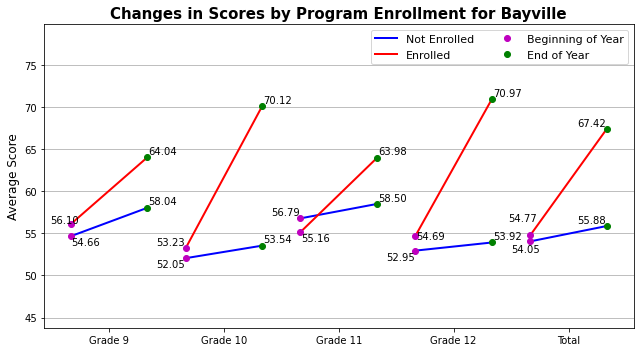

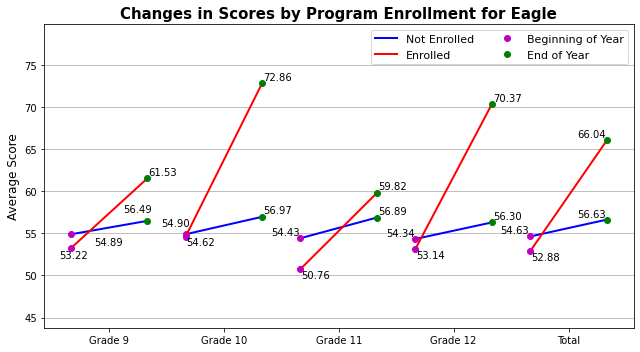

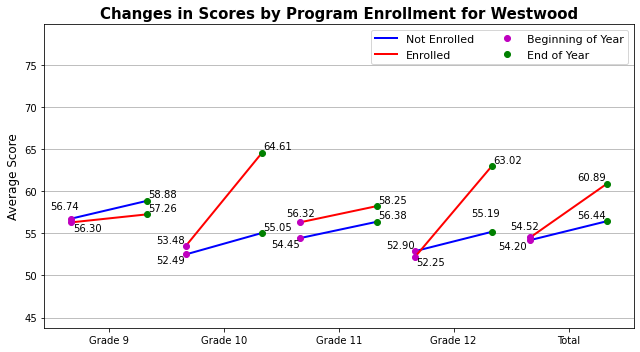

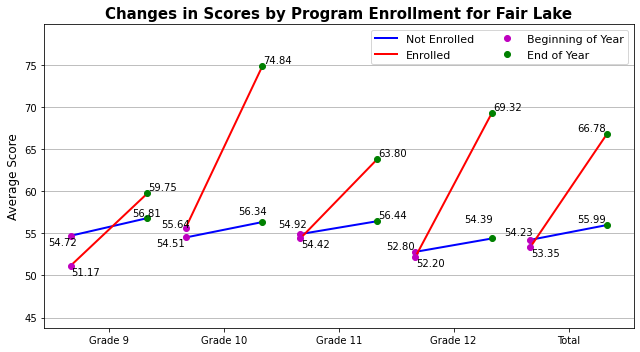

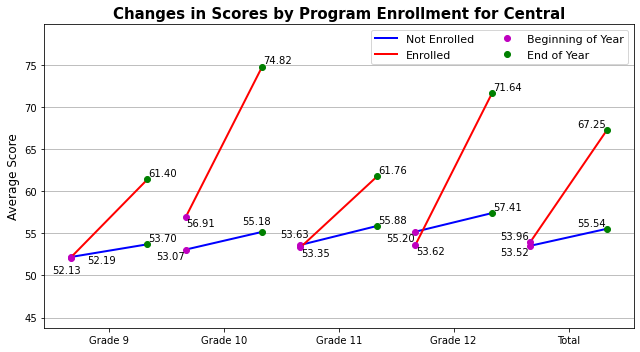

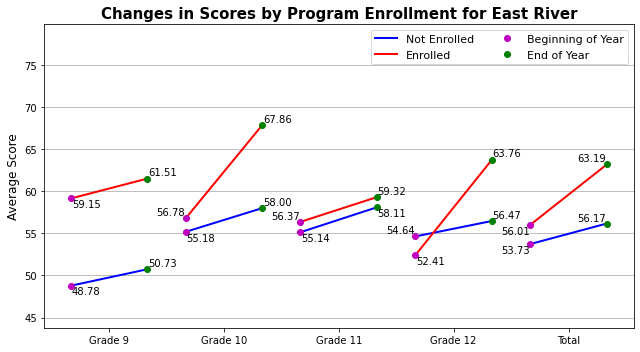

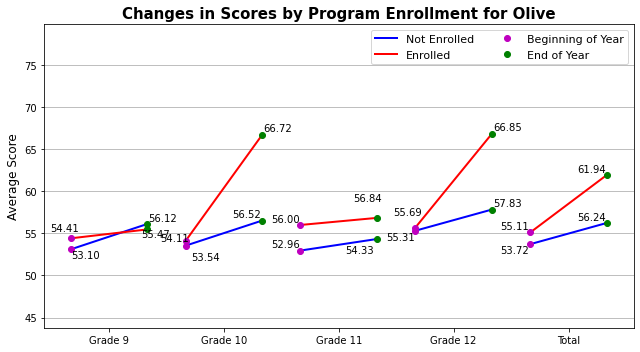

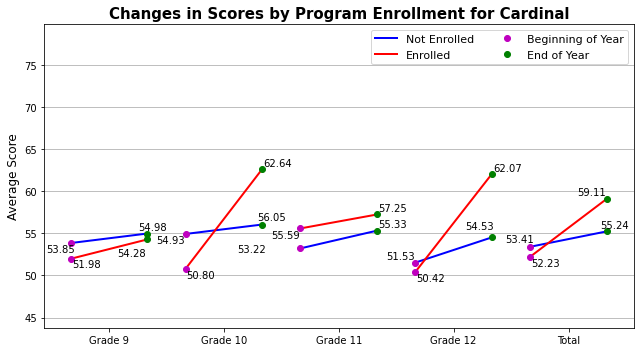

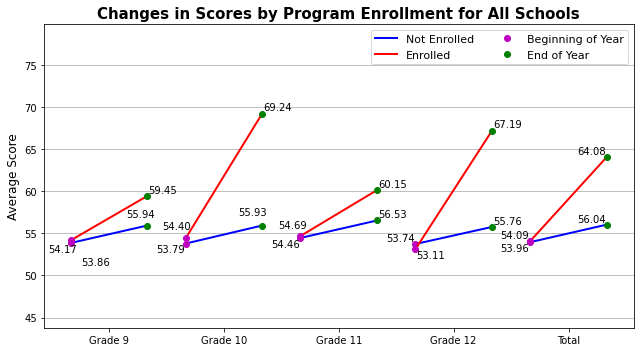

In [15]:
for t in range(len(regression_table_list)): # This loop runs through each database stored in the regression_table_list. i is used as an iterator below and I prefer not to use the same letter for two different iterators within a nested for loop, so I instead used t (for 'tuple') here.
    data_source = regression_table_list[t][1] 
    school = regression_table_list[t][0]

    dl_1 = [0, 1.5, 3, 4.5, 6] 
    dl_2 = [1, 2.5, 4, 5.5, 7]

    fig, ax = plt.subplots(figsize=[9,5]) # The line is based on code from a very helpful Matplotlib tutorial: https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
    fig.set_facecolor('white')
    plt.ylim(all_schools_min-5,all_schools_max+5) # Bases each graph's y axis limits off the minimum and maximum scores found above. The -5 and +5 provide extra room for elements to be plotted on each chart.
    plt.grid(b=True,which='both',axis = 'y') # See https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html


    x_avoid_list = [] 
    y_avoid_list = []
    data_label_list = []

    for i in range(len(data_source.columns)): # This loop runs through each column of the DataFrame accesed in the above for loop ("for t in . . .")
        if i == 0: # This if statement, along with the parameter values in the two plot_line statements below, cause only the first set of labels to be graphed, not the subsequent ones (in order to avoid duplicate labels).
            current_non_enrolled_line_label = 'Not Enrolled'
            current_enrolled_line_label = 'Enrolled'
            current_point_label_1 = 'Beginning of Year'
            current_point_label_2 = 'End of Year'
        else:
            current_non_enrolled_line_label = '_' # Matplotlib documentation notes that "Specific lines can be excluded from the automatic legend element selection by defining a label starting with an underscore" (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html), which is why '_' is used as the default label here.
            current_enrolled_line_label = '_'
            current_point_label_1 = '_'
            current_point_label_2 = '_'

        non_enrolled_yvals = [data_source.loc['Non_Enrolled_BOY_Mean'][data_source.columns[i]], data_source.loc['Non_Enrolled_EOY_Mean'][data_source.columns[i]]] # Creates a list with two values: the BOY and EOY mean scores for the current column within the for loop
        enrolled_yvals = [data_source.loc['Enrolled_BOY_Mean'][data_source.columns[i]], data_source.loc['Enrolled_EOY_Mean'][data_source.columns[i]]]


        # The following set of code uses plot_line to create two lines; these lines connect the two y values in non_enrolled_yvals and enrolled_yvals, respectively.
        plot_line([dl_1[i],dl_2[i]],non_enrolled_yvals,color=('blue'),line_label= current_non_enrolled_line_label)
        plot_line([dl_1[i],dl_2[i]],enrolled_yvals,color=('red'), line_label = current_enrolled_line_label, point_label_1 = current_point_label_1, point_label_2 = current_point_label_2)
    
    
    # Creating data labels for both sets of lines

        for j in range (2): # Loop will start with the values within the non-enrolled students graph and then conclude with the values within the enrolled students graph.
            if j == 0: 
                yval_source = non_enrolled_yvals 
            if j == 1:
                yval_source = enrolled_yvals 
            left_data_label = plt.text(dl_1[i],yval_source[0],'{:.2f}'.format(yval_source[0]),ha='center') 
            data_label_list.append(left_data_label)
            right_data_label = plt.text(dl_2[i],yval_source[1],'{:.2f}'.format(yval_source[1]),ha='center')
            data_label_list.append(right_data_label)

            x_avoid = np.linspace(0,1,21) 
            y_avoid = yval_source[0] + x_avoid*(yval_source[1] - yval_source[0]) # Creates a series of y values that line up with the lines created earlier in this for loop. Each value equals the left y value(yval_source[0]) plus the x value (from 0 to 1) * the total rise of the line from left to right. The purpose of this, as discussed in the Pivot Tables and Graphs Tutorial program (https://github.com/kburchfiel/pivot_tables_and_graphs_tutorial), is to create a set of points that the adjust_text function should avoid when deciding where to place data labels.
            x_avoid += dl_1[i] 
            # plt.plot(x_avoid,y_avoid, color='black') # A useful line for debugging that plots the values in x_avoid and y_avoid. These lines should appear directly over the other lines in the graph, as their purpose is to designate areas that adjust_text should avoid when adjusting the locations of data labels.
            x_avoid_list.extend(x_avoid)
            y_avoid_list.extend(y_avoid)

    adjust_text(data_label_list, x=x_avoid_list, y=y_avoid_list)
    if school == 'Total':
        title_string = "Changes in Scores by Program Enrollment for All Schools"
    else:
        title_string = "Changes in Scores by Program Enrollment for "+school  
    plt.title(title_string,fontweight='bold',fontsize=15)

    xtick_list = []
    for m in range(len(dl_1)):
        xtick_list.append(np.mean([dl_1[m], dl_2[m]])) 
    ax.set_xticks(xtick_list) 

    col_labels = list(data_source.columns.copy()) # Creates a list of all the grades and the 'Total' category in the same order that they appear within the table. The list() operation is necessary in the event that changes to the column names need to be made.
    ax.set_xticklabels(col_labels) # Converts the column names ('Grade 9', 'Grade 10', etc.) into the x axis labels
    ax.set_ylabel('Average Score',fontsize=12)
    plt.tight_layout()
    plt.legend(ncol=2,fontsize=11)
    file_string = 'score_graphs\\'+school.replace(' ','_')+'_score_changes.png' # The replace() method function ensures that there won't be any spaces in the file names.
    plt.savefig(file_string,dpi=400)
    plt.show()

A virtually identical set of graphs was created in the Pivot Tables and Graphs Tutorial program (available at https://github.com/kburchfiel/pivot_tables_and_graphs_tutorial/blob/master/pivot_tables_and_graphs.ipynb). Although these graphs were based off regression outputs, whereas the graphs in the Pivot Tables and Graphs Tutorial prgoram were based off pivot tables, the numbers shown in both graphs are identical. 

# Plotting changes over time via grouped bar charts

The above graphs are useful for showing the actual changes in student scores over the course of the school year. However, I decided to also create grouped bar charts that display the relative magnitudes of the different coefficients within the different DataFrames in regression_table_list. These bar charts will also display which coefficients were found to be statistically significant.

Parts of the code below are similar to that used to create the grouped line charts.

<class 'list'>


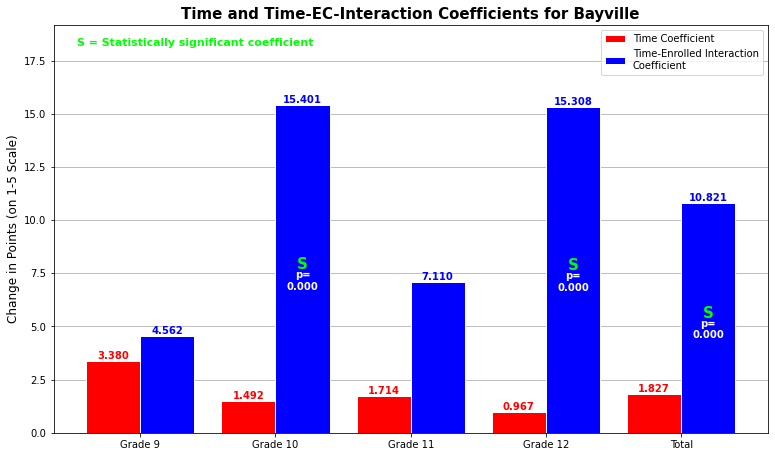

<class 'list'>


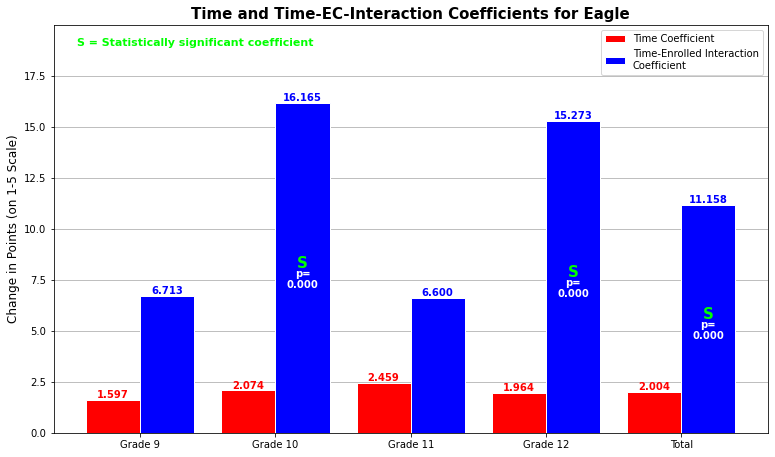

<class 'list'>


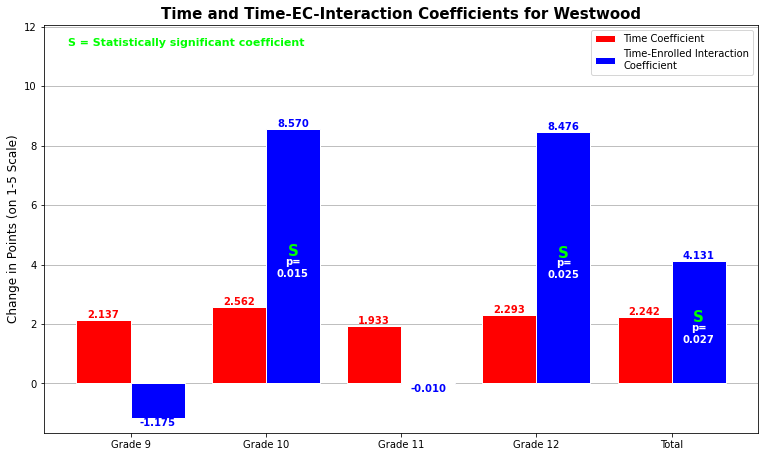

<class 'list'>


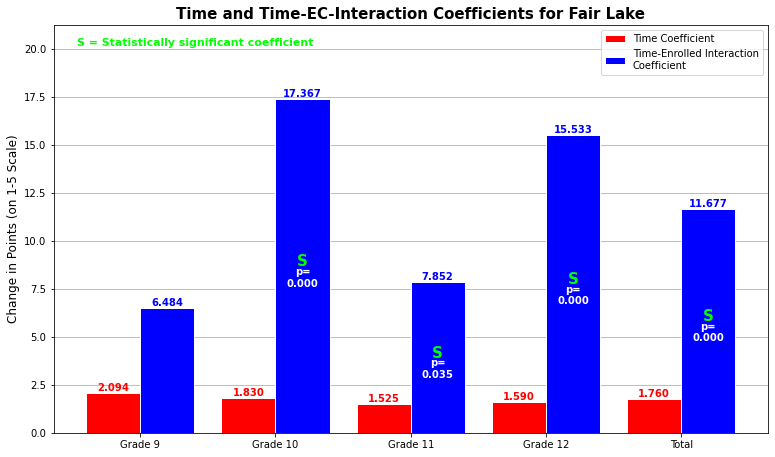

<class 'list'>


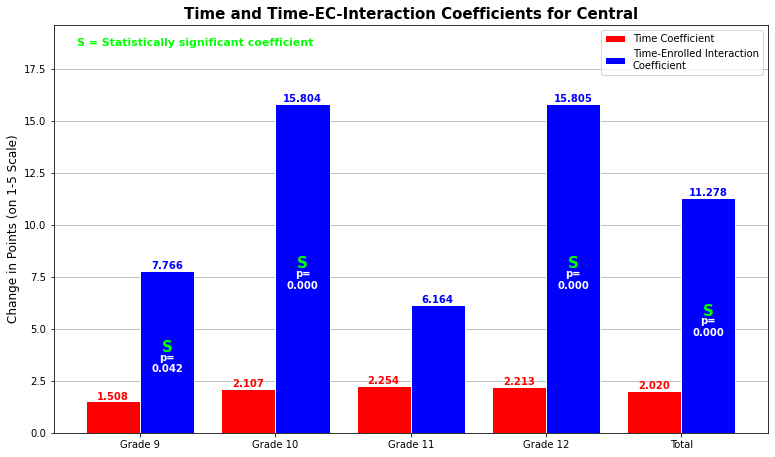

<class 'list'>


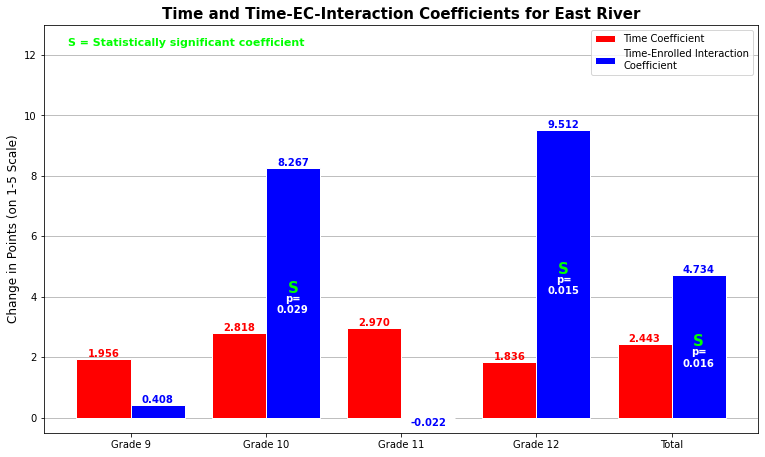

<class 'list'>


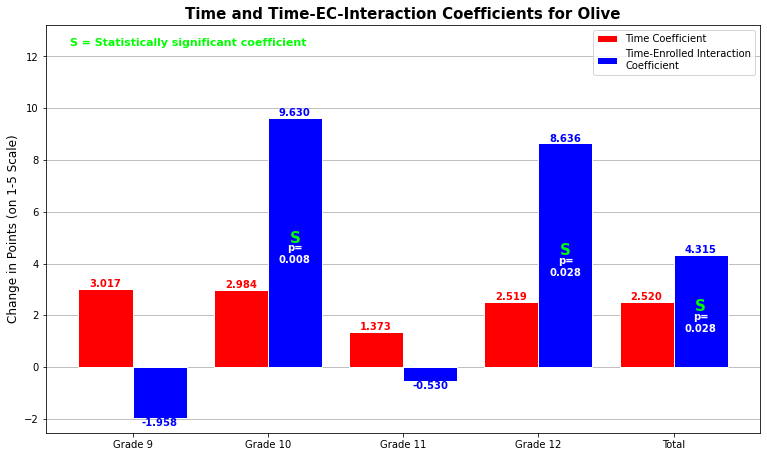

<class 'list'>


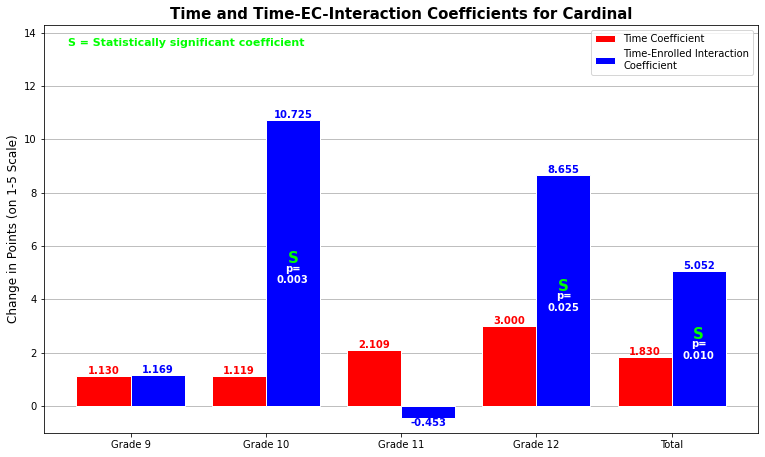

<class 'list'>


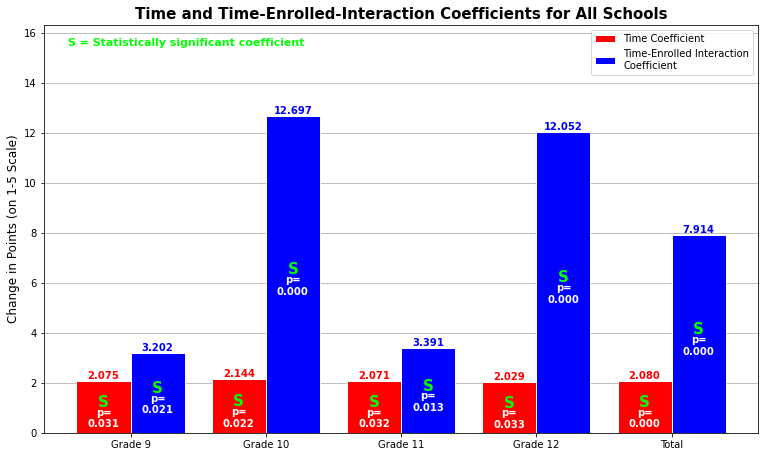

In [16]:
# This code is based on the "Grouped bar chart with labels" Matplotlib tutorial, available here: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

for t in range(len(regression_table_list)): # This loop runs through each database stored in the regression_table_list. i is used as an iterator below and I prefer not to use the same letter for two different iterators within a nested for loop, so I instead used t (for 'tuple') here.

    data_source = regression_table_list[t][1] 
    school = regression_table_list[t][0]

    fig, ax = plt.subplots(figsize=[12.8,7.5]) # Widening the graph gives the x axis labels more space
    col_labels = list(data_source.columns.copy()) 
    print(type(col_labels))
    fig.set_facecolor('white')

    x_values = np.linspace(0,len(col_labels)-1,len(col_labels)) # Creates x values for plotting bars and other features. The list of x values iterates by 1 and is equal to the length of the number of column labels.
    # It's useful to set these manually so that other points on the graph (such as significance labels) can be plotted at the right positions.

    bar_width = 0.4 # This number comes from Matplotlib's grouped bar charts tutorial. Assuming the distance between each group is 1, this value will allow both bar charts in each group to be plotted together while also leaving space between each group. 
    ax.set_xticks(x_values)
    plt.grid(axis = 'y') # https://matplotlib.org/stable/api/_as_gen/matplotlib.artist.Artist.set_zorder.html#matplotlib.artist.Artist.set_zorder
    ax.set_xticklabels(col_labels, rotation = 0)
    ax.set_axisbelow(True) # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_axisbelow.html#matplotlib.axes.Axes.set_axisbelow
    time_coeff_bars = plt.bar(x_values - bar_width/2, data_source.loc['Time_Coeff'][:], bar_width, label='Time Coefficient',color='red',edgecolor='white',linewidth=1) # [:] is used because all columns are being included; however, this could be adjusted to only include a range of columns if needed. Converting the output to a list avoids an error message.
    # bar_width/2 is subtracted from x_values for time_coeff_bars but added to x_values for time_enrolled_interaction_coeff_bars (see below) so that the two bars do not overlap each other. These plt.bar() lines are also based on Matplotlib's grouped bar chart tutorial (https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html)
    time_enrolled_interaction_coeff_bars = plt.bar(x_values + bar_width/2, data_source.loc['EOY_and_Enrolled_Coeff'][:], bar_width, label='Time-Enrolled Interaction\nCoefficient',color='blue',edgecolor='white',linewidth=1) 
    ax.bar_label(time_coeff_bars,label_type = 'edge',color='red',fontweight='bold', fmt='%.3f') # I believe I derived this fmt string, which rounds the data label values to 3 decimal places, from https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html .
    ax.bar_label(time_enrolled_interaction_coeff_bars,label_type = 'edge',color='blue',fontweight='bold', fmt='%.3f')

    ax.set_ylim(min(ax.get_ylim()[0], 0), max(ax.get_ylim()[1]+3,0)) # This code increases the maximum value of the graph's y axis, accessed through ax.get_ylim()[1]), by 3 (or sets it to 0 if it's currently -3 or below), but keeps the current minimum value in place (or sets it to 0 if it's currently above 0).
    ax_height = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax_width = ax.get_xlim()[1] - ax.get_xlim()[0]
    
    # Statistical significance will be represented by a green 'S' that appears on the bar portraying the statistically significant value.

    add_legend_flag = 0 # If a statistically significant result is present in the graph, this value will be set to 1 in order to prompt the code to add a legend explaining that the green 'S' refers to a statistically significant value. If no result is present, this flag will remain 0, and no legend will be added.

    # Adding labels to indicate which coefficients are statistically significant
    for s in range (len(data_source.columns)): # Iterates across the columns of the DataFrame to access its regression results
        if data_source.loc['Time_Significant'][s] == 1:
            plt.text(x_values[s] - bar_width/2, data_source.loc['Time_Coeff'][s]/2, 'S', color = (0, 1, 0), fontsize=15, fontweight='bold', ha = 'center') # Adds a green 'S' to bars with statistically significant values. Using [s]/2 places the point in the middle of the bar. Because the y limits of the axis were set earlier so that 0 would always be included, 'S' should never be hidden from view.
            plt.text(x_values[s] - bar_width/2, data_source.loc['Time_Coeff'][s]/2-ax_height/20, 'p=\n'+'{:.3f}'.format(data_source.loc['Time_Pval'][s]), color = 'white', fontsize=10, fontweight='bold', ha = 'center')
            add_legend_flag = 1 # Adds the p value of the statistically significant result to the graph. -ax_height/[20] offsets the label by a value that scales with the y axis dimensions so that the p value doesn't overlap with the 'S' metric.
        if data_source.loc['EOY_and_Enrolled_Significant'][s] == 1:
            plt.text(x_values[s] + bar_width/2, data_source.loc['EOY_and_Enrolled_Coeff'][s]/2, 'S', color = (0, 1, 0), fontsize=15, fontweight='bold', ha = 'center') 
            plt.text(x_values[s] + bar_width/2, data_source.loc['EOY_and_Enrolled_Coeff'][s]/2-ax_height/20, 'p=\n'+'{:.3f}'.format(data_source.loc['EOY_and_Enrolled_Pval'][s]), color = 'white', fontsize=10, fontweight='bold', ha = 'center')
            add_legend_flag = 1
    if add_legend_flag == 1:
        plt.text(ax.get_xlim()[0]+ax_width/30, ax.get_ylim()[1]-ax_height/20, 'S = Statistically significant coefficient', color = (0, 1, 0), fontweight = 'bold', fontsize = 11)
         
       
    plt.legend(loc = 'upper right')

    ax.set_ylabel('Change in Points (on 1-5 Scale)',fontsize=12)
    if school == 'Total':
        title_string = "Time and Time-Enrolled-Interaction Coefficients for All Schools"        
    else:
        title_string = "Time and Time-EC-Interaction Coefficients for "+school
    plt.title(title_string,fontweight='bold',fontsize=15)

    file_string = 'coeff_graphs\\'+school.replace(' ','_')+'_coeffs.png' # The replace() method function ensures that there won't be any spaces in the file names.
    plt.savefig(file_string,dpi=400)
    plt.show()

Together, the grouped bar charts and grouped line charts reveal a number of findings:

A. At the school district level:
1. There was a statistically significant increase over time in HGMA scores (independent of Code the Concepts enrollment) for all grades.
2. In addition, Code the Concepts enrollment had a statistically significant positive effect on Code the Concepts scores for every grade. This effect was particularly high for 10th and 12th graders.

B. At the individual school level, many coefficients were not significant. This is likely because the sample size is lower among individual grades at a given school than it is for the network as a whole.


Although the graphs produced above make it easier to grasp the effects of time and Code the Concepts enrollment on HGMA scores, the data on which these graphs are based are also a valuable resource. Therefore, the following set of code saves each DataFrame in regression_table_list to its own worksheet within a spreadsheet titled 'regression_tables.xlsx'.

In [17]:
with pd.ExcelWriter('regression_tables.xlsx') as writer:
    for i in range(len(regression_table_list)): 
        regression_table_list[i][1].to_excel(writer, sheet_name = regression_table_list[i][0])

The code below reports how long it took the entire program to run. At one point, for example, the output read:

"Completed run at Sat Jul 24 20:40:55 2021 (local time)
Total run time: 35.56 second(s) (0.0 minute(s) and 35.56 second(s))"

In [18]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only valid when the program is run nonstop from start to finish


Completed run at Tue Aug 24 17:45:28 2021 (local time)
Total run time: 38.86 second(s) (0.0 minute(s) and 38.86 second(s))


I hope this code and commentary will prove useful in your own data analysis work, and that you end up having as much fun learning and applying Python as I have!